In [433]:
#!pip install graphviz

In [434]:
from collections import defaultdict
import graphviz
from collections import defaultdict
from IPython.display import Image, display

In [435]:
# === NGỮ PHÁP TIẾNG VIỆT MỞ RỘNG ===
VN_GRAMMAR = {
    "S": [["NP", "VP"]],

    # Noun phrases
    "NP": [["Pro"], ["N"], ["Det", "N"], ["N", "N"], ["NP", "PP"]], # Added NP PP rule

    # Verb phrases
    "VP": [["NA","VP"], ["V"], ["V", "NP"], ["V", "Adj"], ["V", "PP"], ["Adv", "V"], ["V", "V"], ["V", "Adv"]], # Added V Adv rule

    # Prepositional phrases
    "PP": [["P", "NP"]],

    "NA": [["không"]],

    # Pronouns
    "Pro": [["tôi"], ["em"], ["anh"], ["chị"], ["bạn"], ["bố"], ["mẹ"], ["bé"], ["con"]],

    # Nouns
    "N": [
        ["cơm"], ["bài"], ["chợ"], ["sách"], ["hà nội"], ["cà phê"], ["phim"],
        ["mèo"], ["con mèo"], ["chó"], ["con chó"], ["cờ"], ["tranh"], ["búp bê"], ["nước"], ["báo"], ["mì"],
        ["xe"], ["bánh"], ["nhạc"], ["thư"], ["cây"], ["đồ"], ["tivi"], ["truyện"],
        ["sữa"], ["toán"], ["tiếng anh"], ["đồng hồ"], ["ảnh"], ["phòng"], ["hoa"],
        ["đàn"], ["bộ"], ["chén"], ["trưa"], ["buổi trưa"], ["dạo"], ["điện"], ["ăn"], ["học"],
        #["làm"],
        ["việc"], ["ông bà"], ["bà"], ["tôi"], ["sinh"], ["tố"], ["bánh mì"], ["sinh tố"],
        ["cá koi"], ["học sinh"],["sinh học"],["anh ấy"]
    ],

    # Determiners
    "Det": [["mọi"]],

    # Verbs
    "V": [
        ["ăn"], ["học"], ["đi"], ["đọc"], ["nấu"], ["yêu"], ["thích"]
        #, ["thích"]
        , ["xem"],
        ["ngủ"], ["sủa"], ["chơi"], ["uống"], ["chạy"], ["sửa"], ["làm"], ["nghe"],
        ["mua"], ["viết"], ["tưới"], ["giặt"], ["ngồi"], ["gọi"], ["chờ"], ["rửa"],
        ["dọn"], ["chụp"], ["thăm"], ["lái"], ["làm việc"], ["hát"], ["vẽ"],
        ["chăm"], ["dạo"]
    ],

    # Adjectives – Tính từ
    "Adj": [
        ["nhanh"],
        ["cao"],
        ["thấp"],
        ["đẹp"],
        ["xinh"],
        ["giỏi"],
        ["trẻ"],
        ["mới"],
        ["nóng"],
        ["vui"],
        #["tốt"],
    ],

    "Adv": [
        ["rất"],
        ["hơi"],
        ["thường"],
        ["luôn"],
        ["cẩn thận"],
        ["vội"],
        ["chậm"],
        ["đột ngột"],
        ["từ tốn"]
    ],

    # Prepositions
    "P": [
        ["ở"], ["trong"], ["trên"], ["dưới"], ["với"],
        ["bằng"], ["về"], ["từ"], ["đến"], ["qua"], ["vào"]
    ]
}


In [436]:
# === NODE CLASS FOR PARSE TREE ===
class ParseNode:
    def __init__(self, symbol, children=None, word=None):
        self.symbol = symbol
        self.children = children if children is not None else []
        self.word = word  # For terminal nodes, store the actual word(s)

    def __repr__(self):
        if self.word:
            return f"{self.symbol}('{self.word}')"
        return f"{self.symbol}({len(self.children)} children)"

# === STATE CLASS ===
class State:
    def __init__(self, lhs, rhs, dot, start, end, backpointers=None, node=None):
        self.lhs = lhs
        self.rhs = rhs
        self.dot = dot
        self.start = start
        self.end = end
        self.backpointers = backpointers if backpointers else []  # Store (state, completed_state) pairs
        self.node = node  # ParseNode associated with this state

    def next_symbol(self):
        return self.rhs[self.dot] if self.dot < len(self.rhs) else None

    def is_complete(self):
        return self.dot >= len(self.rhs)

    def advance(self):
        return State(self.lhs, self.rhs, self.dot + 1, self.start, self.end, self.backpointers)

    def __eq__(self, other):
        return (self.lhs, self.rhs, self.dot, self.start, self.end) == \
               (other.lhs, other.rhs, other.dot, other.start, other.end)

    def __hash__(self):
        return hash((self.lhs, tuple(self.rhs), self.dot, self.start, self.end))

    def __repr__(self):
        before_dot = ' '.join(self.rhs[:self.dot])
        after_dot = ' '.join(self.rhs[self.dot:])
        return f"[{self.start}:{self.end}] {self.lhs} → {before_dot} • {after_dot}"

# === MODIFIED PARSER ===
def parse_vietnamese(sentence, grammar=VN_GRAMMAR):
    words = sentence.lower().strip().split()

    n = len(words)
    chart = [set() for _ in range(n + 1)]
    # Initialize with start symbol
    for rhs in grammar["S"]:
        chart[0].add(State("S", rhs, 0, 0, 0))

    for i in range(n + 1):
        added = True
        while added:
            added = False
            states = list(chart[i])
            for state in states:
                next_sym = state.next_symbol()

                if next_sym in grammar:
                    for prod in grammar[next_sym]:
                        new_state = State(next_sym, prod, 0, i, i)
                        if new_state not in chart[i]:
                            chart[i].add(new_state)
                            added = True

                elif next_sym is not None and next_sym not in grammar:
                    terminal_words = next_sym.split()
                    terminal_len = len(terminal_words)
                    if i + terminal_len <= n and words[i:i + terminal_len] == terminal_words:
                        # Create a ParseNode for the terminal
                        terminal_text = ' '.join(words[i:i + terminal_len])
                        #print(, state.rhs)
                        node = ParseNode(state.lhs, word=terminal_text)
                        new_state = State(state.lhs, state.rhs, state.dot + 1, state.start, i + terminal_len, state.backpointers, node)
                        if new_state not in chart[i + terminal_len]:
                            chart[i + terminal_len].add(new_state)
                            added = True

                elif state.is_complete():
                    for st in chart[state.start]:
                        if st.next_symbol() == state.lhs:
                            # Create a ParseNode for the completed rule
                            children = []
                            backpointers = st.backpointers + [(st, state)]
                            for _, completed_state in backpointers:
                                if completed_state.node:
                                    children.append(completed_state.node)
                            node = ParseNode(st.lhs, children=children)
                            new_state = State(st.lhs, st.rhs, st.dot + 1, st.start, i, backpointers, node)
                            if new_state not in chart[i]:
                                chart[i].add(new_state)
                                added = True

    # Check for success and collect parse trees
    success = False
    parse_trees = []
    for state in chart[n]:
        if state.lhs == "S" and state.start == 0 and state.end == n and state.is_complete():
            success = True
            if state.node:
                parse_trees.append(state.node)
            break

    return success, chart, parse_trees
# === 50 CÂU TIẾNG VIỆT ===
sentences = [
    "Tôi ăn cơm", "Em học bài", "Chị đi chợ", "Bố đọc sách", "Mẹ nấu ăn", "Tôi yêu Hà Nội", "Anh thích cà phê", "Bạn xem phim",
    "Con mèo ngủ", "Con chó sủa", "Ông bà chơi cờ", "Tôi hát", "Em vẽ tranh", "Bé chơi búp bê", "Tôi uống nước", "Anh đọc báo",
    "Em chạy nhanh", "Chị nấu mì", "Bố sửa xe", "Mẹ làm bánh", "Tôi nghe nhạc", "Bạn làm bài", "Anh đi học", "Em mua sách", "Chị chơi đàn",
    "Tôi đi bộ", "Anh rửa chén", "Em viết thư", "Bố tưới cây", "Mẹ giặt đồ", "Tôi ngủ trưa", "Em xem tivi", "Chị đi xe", "Anh học Toán",
    "Tôi đi làm", "Bạn học tiếng Anh", "Em đọc truyện", "Anh uống sữa", "Chị thăm bà", "Tôi đi dạo", "Bạn ngồi học", "Mẹ gọi tôi", "Em xem đồng hồ",
    "Tôi chờ xe", "Anh lái xe", "Chị làm việc", "Bạn gọi điện", "Tôi chụp ảnh", "Em dọn phòng", "Chị chăm hoa"
]

# === CHẠY PARSER CHO 50 CÂU ===
print("=== KIỂM TRA 50 CÂU TIẾNG VIỆT ===\n")
passed = 0
failed_sentences = []

for s in sentences:
    success, _, parse_trees = parse_vietnamese(s)
    if success:
        print(f"THÀNH CÔNG: \"{s}\"")
        passed += 1
    else:
        print(f"THẤT BẠI: \"{s}\"")
        failed_sentences.append(s)

print(f"\nĐã phân tích thành công: {passed}/{len(sentences)} câu")

if failed_sentences:
    print("\n=== CÁC CÂU CHƯA PHÂN TÍCH ĐƯỢC ===")
    for s in failed_sentences:
        print(f"- \"{s}\"")

# === PHÂN TÍCH CÂU KHÓ ===
def analyze_sentence(sentence):
    """Phân tích chi tiết câu và hiển thị trạng thái phân tích"""
    print(f"\n=== PHÂN TÍCH CHI TIẾT: \"{sentence}\" ===")
    #words = sentence.strip().split()
    success, chart, parse_trees = parse_vietnamese(sentence)

    for i, states in enumerate(chart):
        print(f"\nCHART[{i}]:")
        for state in sorted(states, key=lambda s: (s.start, s.lhs)):
            print(f"  {state}")

    if success:
        print(f"\nTHÀNH CÔNG: Câu \"{sentence}\" được phân tích thành công")
        parse_trees
    else:
        print(f"\nTHẤT BẠI: Câu \"{sentence}\" không thể phân tích")

# Phân tích một số câu khó
#problem_sentences = ["Ông bà chơi cờ", "Mẹ nấu ăn", "Tôi đi bộ", "Tôi đi làm"]
#for sentence in problem_sentences:
#    analyze_sentence(sentence)

=== KIỂM TRA 50 CÂU TIẾNG VIỆT ===

THÀNH CÔNG: "Tôi ăn cơm"
THÀNH CÔNG: "Em học bài"
THÀNH CÔNG: "Chị đi chợ"
THÀNH CÔNG: "Bố đọc sách"
THÀNH CÔNG: "Mẹ nấu ăn"
THÀNH CÔNG: "Tôi yêu Hà Nội"
THÀNH CÔNG: "Anh thích cà phê"
THÀNH CÔNG: "Bạn xem phim"
THÀNH CÔNG: "Con mèo ngủ"
THÀNH CÔNG: "Con chó sủa"
THÀNH CÔNG: "Ông bà chơi cờ"
THÀNH CÔNG: "Tôi hát"
THÀNH CÔNG: "Em vẽ tranh"
THÀNH CÔNG: "Bé chơi búp bê"
THÀNH CÔNG: "Tôi uống nước"
THÀNH CÔNG: "Anh đọc báo"
THÀNH CÔNG: "Em chạy nhanh"
THÀNH CÔNG: "Chị nấu mì"
THÀNH CÔNG: "Bố sửa xe"
THÀNH CÔNG: "Mẹ làm bánh"
THÀNH CÔNG: "Tôi nghe nhạc"
THÀNH CÔNG: "Bạn làm bài"
THÀNH CÔNG: "Anh đi học"
THÀNH CÔNG: "Em mua sách"
THÀNH CÔNG: "Chị chơi đàn"
THÀNH CÔNG: "Tôi đi bộ"
THÀNH CÔNG: "Anh rửa chén"
THÀNH CÔNG: "Em viết thư"
THÀNH CÔNG: "Bố tưới cây"
THÀNH CÔNG: "Mẹ giặt đồ"
THÀNH CÔNG: "Tôi ngủ trưa"
THÀNH CÔNG: "Em xem tivi"
THÀNH CÔNG: "Chị đi xe"
THÀNH CÔNG: "Anh học Toán"
THÀNH CÔNG: "Tôi đi làm"
THÀNH CÔNG: "Bạn học tiếng Anh"
THÀNH CÔNG: "Em 

In [437]:
# Phân tích một số câu khó
#problem_sentences = ["Ông bà chơi cờ", "Mẹ nấu ăn", "Tôi đi bộ", "Tôi đi làm"]
#problem_sentences = ["Tôi đi làm"]
#for sentence in problem_sentences:
#    analyze_sentence(sentence)

In [438]:
def visualize_parse_tree(sentence, output_file="parse_tree", format="png"):
    """
    Visualizes the parse tree for a given Vietnamese sentence, showing one extra level before displaying the word.
    Args:
        sentence (str): The input sentence to parse and visualize.
        output_file (str): Base name for the output file (without extension).
        format (str): Output format (e.g., 'png', 'svg').
    Returns:
        bool: True if visualization was successful, False otherwise.
    """
    # Parse the sentence
    success, _, parse_trees = parse_vietnamese(sentence)
    if not success or not parse_trees:
        print(f"Failed to parse sentence: \"{sentence}\"")
        return False

    # Use the first parse tree (if multiple exist)
    parse_tree = parse_trees[0]

    # Create a Graphviz Digraph
    dot = graphviz.Digraph(comment=f"Parse Tree for: {sentence}", format=format)
    dot.attr(rankdir="TB")  # Top to Bottom

    # Counter for unique node IDs
    node_id = 0
    node_map = {}  # Maps ParseNode objects to Graphviz node IDs

    def add_node(node, parent_id=None):
        nonlocal node_id
        # Create a unique ID for the node
        current_id = f"n{node_id}"
        node_id += 1
        node_map[node] = current_id

        # Label the node
        if node.word:
            # If it's a terminal node, just show the symbol for this level
            label = node.symbol
        else:
            label = node.symbol

        # Add the node to the graph
        dot.node(current_id, label)

        # If there's a parent, add an edge
        if parent_id:
            dot.edge(parent_id, current_id)

        # Recursively add children
        if node.word:
            # If it's a terminal node, add an extra node below it to show the word
            word_id = f"word_{node_id}"
            node_id += 1
            dot.node(word_id, node.word, shape='none') # Use shape='none' for plain text
            dot.edge(current_id, word_id)
        else:
            for child in node.children:
                add_node(child, current_id)

        return current_id

    # Build the graph starting from the root
    add_node(parse_tree)

    # Render and display the graph
    try:
        if format == "png":
            # Render to PNG and display
            display(Image(dot.pipe(format='png')))
        elif format == "svg":
            # Render to SVG and display
            from IPython.display import SVG
            display(SVG(dot.pipe(format='svg')))
        else:
            print(f"Unsupported format: {format}. Use 'png' or 'svg'.")
            return False
        print(f"Câu: {sentence}")
        return True
    except Exception as e:
        print(f"Error generating parse tree: {e}")
        return False

In [439]:
# === VISUALIZE PARSE TREE FUNCTION ===
def visualize_parse_tree1(sentence, output_file="parse_tree", format="png"):
    """
    Visualizes the parse tree for a given Vietnamese sentence.
    Args:
        sentence (str): The input sentence to parse and visualize.
        output_file (str): Base name for the output file (without extension).
        format (str): Output format (e.g., 'png', 'pdf').
    Returns:
        bool: True if visualization was successful, False otherwise.
    """
    # Parse the sentence
    success, _, parse_trees = parse_vietnamese(sentence)

    if not success or not parse_trees:
        print(f"Failed to parse sentence: \"{sentence}\"")
        return False

    # Use the first parse tree (if multiple exist)
    parse_tree = parse_trees[0]

    # Create a Graphviz Digraph
    dot = graphviz.Digraph(comment=f"Parse Tree for: {sentence}", format=format)
    dot.attr(rankdir="TB")  # Top to Bottom

    # Counter for unique node IDs
    node_id = 0
    node_map = {}  # Maps ParseNode objects to Graphviz node IDs

    def add_node(node):
        nonlocal node_id
        # Create a unique ID for the node
        current_id = f"n{node_id}"
        node_id += 1
        node_map[node] = current_id

        # Label the node
        if node.word:
            label = f"{node.symbol}\n({node.word})"
            #label = f"1\n({node.word})"
        else:
            label = node.symbol

        # Add the node to the graph
        dot.node(current_id, label)

        # Recursively add children
        for child in node.children:
            child_id = add_node(child)
            dot.edge(current_id, child_id)

        return current_id

    # Build the graph starting from the root
    add_node(parse_tree)

    # Render the graph
    try:
        dot.render(output_file, view=False, cleanup=False)
        print(f"Parse tree saved as {output_file}.{format}")
        return True
    except Exception as e:
        print(f"Error rendering parse tree: {e}")
        return False

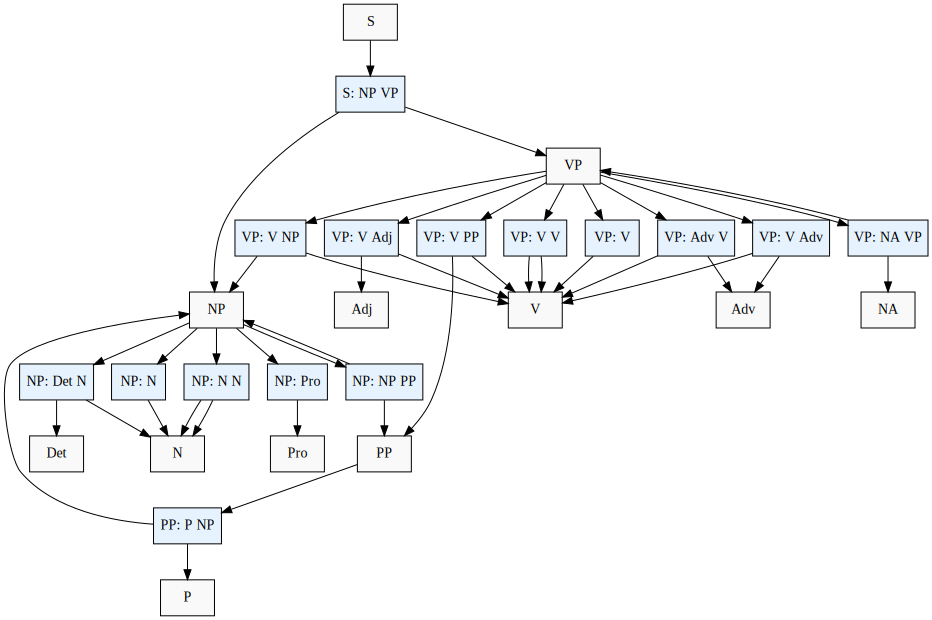

In [440]:
def visualize_grammar_tree_graphviz(grammar, show_terminals=False):
    """
    Tạo biểu đồ cây cú pháp sử dụng Graphviz

    Args:
        grammar: Từ điển chứa các luật ngữ pháp
        show_terminals: Có hiển thị các từ kết thúc (terminal words) hay không

    Returns:
        Đối tượng Graphviz Digraph
    """
    # Tạo đối tượng Digraph
    dot = graphviz.Digraph(comment='Grammar Tree')
    dot.attr('node', shape='box', style='filled', fillcolor='#f9f9f9')

    node_count = 0
    node_map = {}  # Lưu ánh xạ giữa non-terminal và ID node

    # Tạo những nút gốc cho các loại cấu trúc ngữ pháp
    for symbol in grammar:
        node_id = f"{symbol}_{node_count}"
        node_map[symbol] = node_id
        dot.node(node_id, symbol)
        node_count += 1

    # Xử lý các luật mở rộng cho mỗi ký hiệu phi kết thúc (non-terminal)
    for symbol, expansions in grammar.items():
        parent_node = node_map[symbol]  # Lấy nút gốc cho ký hiệu

        # Xử lý mỗi luật mở rộng
        for i, expansion in enumerate(expansions):
            # Kiểm tra xem expansion có chứa terminal nodes không
            contains_only_terminals = all(comp not in grammar for comp in expansion)

            # Nếu chỉ chứa terminals và không hiển thị terminals, thì bỏ qua
            if contains_only_terminals and not show_terminals:
                continue

            # Tạo một nút mở rộng cho mỗi luật - bỏ qua các terminal words nếu show_terminals=False
            if show_terminals:
                expansion_label = f"{symbol}: {' '.join(expansion)}"
            else:
                # Chỉ hiển thị các non-terminals trong expansion
                non_terminal_parts = [comp for comp in expansion if comp in grammar]
                if non_terminal_parts:  # Chỉ hiển thị nếu có non-terminals
                    expansion_label = f"{symbol}: {' '.join(non_terminal_parts)}"
                else:
                    # Nếu expansion chỉ chứa terminals, hiển thị tên symbol để người dùng biết luật tồn tại
                    expansion_label = f"{symbol}: ..."

            expansion_id = f"{symbol}_exp_{i}"
            dot.node(expansion_id, expansion_label, fillcolor='#e6f3ff')
            dot.edge(parent_node, expansion_id)

            # Xử lý từng thành phần trong luật mở rộng
            for j, component in enumerate(expansion):
                # Chỉ xử lý các non-terminals
                if component in grammar:
                    # Kết nối đến nút gốc của nó
                    child_node = node_map[component]
                    dot.edge(expansion_id, child_node)
                elif show_terminals:  # Chỉ hiển thị terminals khi show_terminals=True
                    terminal_id = f"term_{node_count}"
                    dot.node(terminal_id, component, fillcolor='#f0e6ff')
                    dot.edge(expansion_id, terminal_id)
                    node_count += 1

    return dot

# Tạo biểu đồ cây cú pháp (không hiển thị các từ kết thúc)
graph = visualize_grammar_tree_graphviz(VN_GRAMMAR, show_terminals=False)

# Hiển thị biểu đồ
graph

In [441]:
# === VISUALIZE PARSE TREE FUNCTION ===
def visualize_parse_tree1(sentence, output_file="parse_tree", format="png"):
    """
    Visualizes the parse tree for a given Vietnamese sentence.
    Args:
        sentence (str): The input sentence to parse and visualize.
        output_file (str): Base name for the output file (without extension).
        format (str): Output format (e.g., 'png', 'svg').
    Returns:
        bool: True if visualization was successful, False otherwise.
    """
    # Parse the sentence
    success, _, parse_trees = parse_vietnamese(sentence)
    print(parse_trees)
    if not success or not parse_trees:
        print(f"Failed to parse sentence: \"{sentence}\"")
        return False

    # Use the first parse tree (if multiple exist)
    parse_tree = parse_trees[0]

    # Create a Graphviz Digraph
    dot = graphviz.Digraph(comment=f"Parse Tree for: {sentence}", format=format)
    dot.attr(rankdir="TB")  # Top to Bottom

    # Counter for unique node IDs
    node_id = 0
    node_map = {}  # Maps ParseNode objects to Graphviz node IDs

    def add_node(node):
        nonlocal node_id
        # Create a unique ID for the node
        current_id = f"n{node_id}"
        node_id += 1
        node_map[node] = current_id

        # Label the node
        if node.word:
            label = f"{node.symbol}\n({node.word})"
        else:
            label = node.symbol

        # Add the node to the graph
        dot.node(current_id, label)

        # Recursively add children
        for child in node.children:
            child_id = add_node(child)
            dot.edge(current_id, child_id)

        return current_id

    # Build the graph starting from the root
    add_node(parse_tree)

    # Render and display the graph
    try:
        if format == "png":
            # Render to PNG and display
            display(Image(dot.pipe(format='png')))
        elif format == "svg":
            # Render to SVG and display
            from IPython.display import SVG
            display(SVG(dot.pipe(format='svg')))
        else:
            print(f"Unsupported format: {format}. Use 'png' or 'svg'.")
            return False
        print(f"Câu: {sentence}")
        return True
    except Exception as e:
        print(f"Error generating parse tree: {e}")
        return False



In [450]:
# === EXAMPLE USAGE ===
if __name__ == "__main__":
    # Test with a simple sentence
    test_sentence = "tôi ăn bánh mì"
    test_sentence = "tôi mua bánh mì"
    test_sentence = "tôi mua sinh tố"
    test_sentence = "Anh thích cà phê cá koi"
    test_sentence = "tôi không thích cà phê"
    test_sentence = "tôi rửa chén vào buổi trưa"
    test_sentence = "con mèo ngủ"
    test_sentence = "tôi rất thích đi vào rừng"

    parse_graph = visualize_parse_tree(test_sentence, format="png")
    #analyze_sentence(test_sentence)
    #parse_graph


Failed to parse sentence: "tôi rất thích đi vào rừng"


In [443]:
#!pip install nltk
# %%
from nltk import Tree
# %%
# ... (your existing code for ParseNode, State, parse_vietnamese) ...
# Make sure parse_vietnamese returns a structure compatible with NLTK's Tree

# Function to convert your ParseNode structure to NLTK Tree
def convert_to_nltk_tree(node):
    if node.word:
        return Tree(node.symbol, [node.word])
    else:
        return Tree(node.symbol, [convert_to_nltk_tree(child) for child in node.children])
# %%
# === VISUALIZE PARSE TREE FUNCTION USING NLTK ===
def visualize_parse_tree_nltk(sentence):
    """
    Visualizes the parse tree using NLTK's pretty_print.
    Args:
        sentence (str): The input sentence to parse and visualize.
    """
    success, _, parse_trees = parse_vietnamese(sentence)

    if not success or not parse_trees:
        print(f"Failed to parse sentence: \"{sentence}\"")
        return

    # Use the first parse tree (if multiple exist)
    parse_tree = parse_trees[0]

    # Convert your custom ParseNode tree to NLTK Tree
    nltk_tree = convert_to_nltk_tree(parse_tree)

    # Pretty print the NLTK tree
    #print(f"\nParse Tree for: \"{sentence}\"")
    nltk_tree.pretty_print(unicodelines=True)


In [448]:
passed = 1
for s in sentences:
    success, _, parse_trees = parse_vietnamese(s)
    if success:
        print(f"{passed}. PHÂN TÍCH THÀNH CÔNG CÂU: \"{s}\"")
        passed += 1
        visualize_parse_tree_nltk(s)


1. PHÂN TÍCH THÀNH CÔNG CÂU: "Tôi ăn cơm"
     S         
 ┌───┴───┐      
 │       VP    
 │   ┌───┴───┐  
 NP  │       NP
 │   │       │  
Pro  V       N 
 │   │       │  
tôi  ăn     cơm

2. PHÂN TÍCH THÀNH CÔNG CÂU: "Em học bài"
     S         
 ┌───┴───┐      
 │       VP    
 │   ┌───┴───┐  
 NP  │       NP
 │   │       │  
Pro  V       N 
 │   │       │  
 em học     bài

3. PHÂN TÍCH THÀNH CÔNG CÂU: "Chị đi chợ"
     S         
 ┌───┴───┐      
 │       VP    
 │   ┌───┴───┐  
 NP  │       NP
 │   │       │  
Pro  V       N 
 │   │       │  
chị  đi     chợ

4. PHÂN TÍCH THÀNH CÔNG CÂU: "Bố đọc sách"
     S          
 ┌───┴───┐       
 │       VP     
 │   ┌───┴───┐   
 NP  │       NP 
 │   │       │   
Pro  V       N  
 │   │       │   
 bố đọc     sách

5. PHÂN TÍCH THÀNH CÔNG CÂU: "Mẹ nấu ăn"
     S         
 ┌───┴───┐      
 NP      VP    
 │   ┌───┴───┐  
Pro  V       V 
 │   │       │  
 mẹ nấu      ăn

6. PHÂN TÍCH THÀNH CÔNG CÂU: "Tôi yêu Hà Nội"
     S            
 ┌──